In [1]:
from images.scripts_helper import RobotStats
import cPickle as pickle
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib
import numpy as np
import inspect
from numbers import Number
%matplotlib inline

f = open('/Users/beijbom/Dropbox/dummyfigs/rs3.pkld', 'r')
db = pickle.load(f)

def best_per_source(db, metric):
    source_ids = np.unique(map(lambda x: x.source_id, db))
    dbnew = []
    for source_id in source_ids:
        db_sub =[(row) for row in db if row.source_id == source_id]
        db_valid =[(row) for row in db_sub if isinstance(getattr(row, metric),(int, np.float32, np.float64))]
        if len(db_valid) > 0:
            dbnew.append(db_valid[np.argmax(map(lambda row: getattr(row, metric), db_valid))])
    return dbnew

def remove_small(db, th):
    sizes = np.unique(map(lambda x: x.nsamples_org, db))
    return [(row) for row in db if row.nsamples_org > th]

def valid_alleviation(db):
    return [(row) for row in db if isinstance(row.allevation_level, (int, np.float32, np.float64))]
    

(dir(db[0]), len(db))




(['__doc__',
  '__init__',
  '__module__',
  'active',
  'allevation_level',
  'c_opt',
  'date',
  'fullacc',
  'fullkappa',
  'funcacc',
  'funckappa',
  'gamma_opt',
  'label_threshold',
  'nlabels',
  'nsamples_org',
  'nsamples_pruned',
  'source_id',
  'target_nbr_samples_final',
  'target_nbr_samples_hp',
  'train_time',
  'version'],
 790)

### Look at the various options of nbr samples used in training

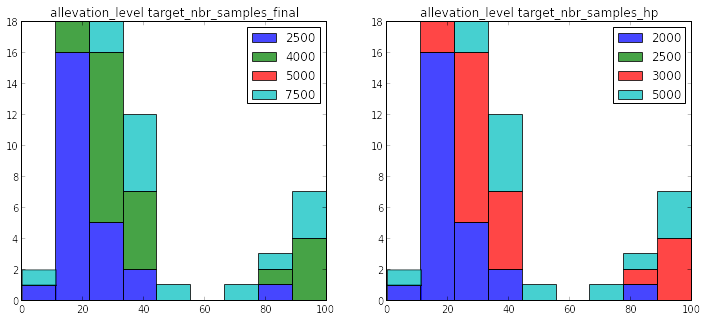

In [110]:
def train_size_plotter(metric):
    yss = [1, 1]
    for (itt, field) in enumerate(['target_nbr_samples_final', 'target_nbr_samples_hp']):
        ys = []
        target_vals = np.unique(map(lambda x: getattr(x, field), db))
        for val in target_vals:
            db_sub =[(row) for row in db if getattr(row, field) == val]
            db_valid =[(row) for row in db_sub if isinstance(getattr(row, metric),(int, np.float32, np.float64))]
            ys.append(map(lambda x:(getattr(x, metric)), db_valid))
        plt.subplot(1, 2, itt+1)
        plt.hist(ys, bins = np.linspace(0, 100, 10), rwidth = 3, histtype = 'barstacked', alpha = .85)
        plt.title(metric + " " + field)
        plt.legend(target_vals)
        yss[itt] = ys
    return yss
        
pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
train_size_plotter("allevation_level")
plt.show()


### Line & surface plot for accuracy

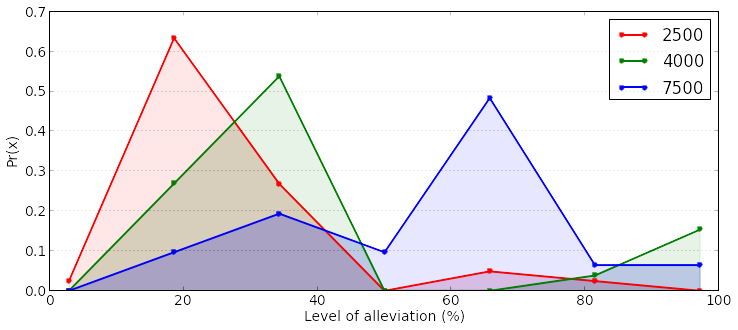

In [22]:
metric = "allevation_level"
target_vals = [2500, 4000, 7500]
bins = np.linspace(-5, 105, 8)
pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
colors = ['red', 'green', 'blue']
font = {'size'   : 14, 'weight' : 'normal'}
matplotlib.rc('font', **font)
for (itt, val) in enumerate(target_vals):
    db_sub =[(row) for row in db if getattr(row, "target_nbr_samples_final") == val]
    db_valid =[(row) for row in db_sub if isinstance(getattr(row, metric),(int, np.float32, np.float64))]
    ys = map(lambda x:(getattr(x, metric)), db_valid)
    vals, a = np.histogram(ys, bins = bins)
    vals = np.float32(vals) / sum(vals)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    plt.plot(bincenters, vals, color = colors[itt], marker = '.', markersize = 10, linewidth = 2)
    plt.fill_between(bincenters, vals, color = colors[itt], alpha = .3)
plt.legend(target_vals)
plt.grid(b = 'on', axis='y')
plt.xlabel('Level of alleviation (%)')
plt.ylabel('Pr(x)')
plt.savefig('alleviation_stats_trainsize_breakdown.png', dpi=400)


### Accuracy and alleviate plots for the thesis. 

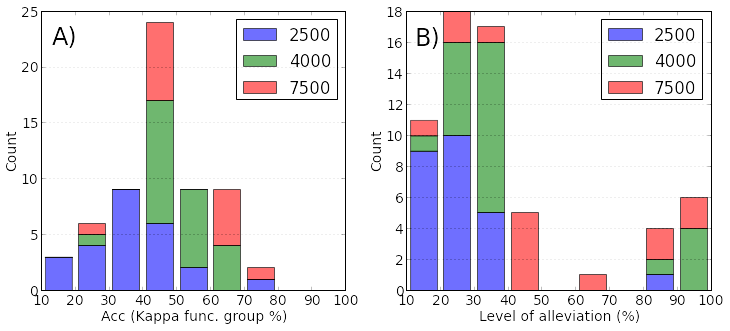

In [22]:
pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
target_vals = [2500, 4000, 7500]
def standard_barplot(db, metric, multiplier):
    ys = []
    for val in target_vals:
        db_sub =[(row) for row in db if row.target_nbr_samples_final == val]
        ys.append(map(lambda x:(multiplier*getattr(x, metric)), db_sub))
            
    plt.hist(ys, bins = np.linspace(10,100,10), alpha = .75, histtype='barstacked')
    plt.legend(target_vals)
    plt.grid(b = 'on', axis='y')
    plt.ylabel("Count")

font = {'size'   : 14, 'weight' : 'normal'}
matplotlib.rc('font', **font)
plt.subplot(1, 2, 1)        
standard_barplot(valid_alleviation(remove_small(db, 5000)), 'funckappa', 100)
plt.text(13, 22, 'A)', fontsize = 24)
plt.xlabel("Acc (Kappa func. group %)")

plt.subplot(1, 2, 2)        
standard_barplot(valid_alleviation(remove_small(db, 5000)), 'allevation_level', 1)

plt.xlabel("Level of alleviation (%)")
plt.text(13, 15.8, 'B)', fontsize = 24)

plt.savefig('cnstats_acc_all.png', dpi=400)


### Correlation between accuracy and nbr samples.

In [46]:
def accuracy_scatter(db, xfield, yfield, ymult = 1):
    for (i, val) in enumerate(target_vals):
        db_sub =[(row) for row in db if row.target_nbr_samples_final == val]
        yvals = map(lambda x:getattr(x, yfield)*ymult, db_sub)
        xvals = map(lambda x:getattr(x, xfield), db_sub)
        plt.scatter(xvals, yvals, color=colors[i])


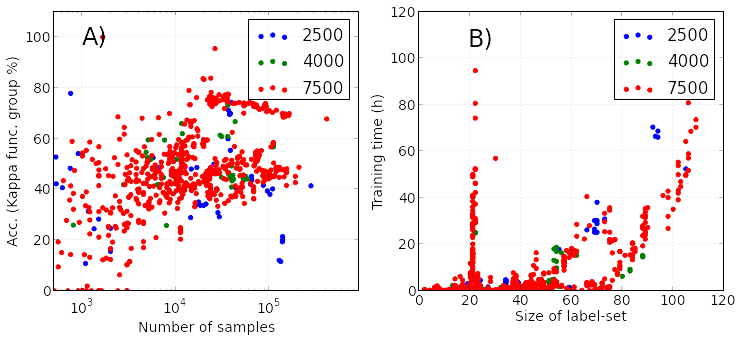

In [62]:
colors = ['blue', 'green', 'red'] 
target_vals = [2500, 4000, 7500]
pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
font = {'size'   : 14, 'weight' : 'normal'}
matplotlib.rc('font', **font)


plt.subplot(1, 2, 1)
accuracy_scatter(db, "nsamples_org", "funckappa", ymult= 100)
plt.legend(target_vals)
plt.xscale('log')
plt.xlim([500, 900000])
plt.text(1000, 97, 'A)', fontsize = 24)
plt.ylim([0, 110])
plt.ylabel('Acc. (Kappa func. group %)')
plt.xlabel('Number of samples')
plt.grid('on')

plt.subplot(1, 2, 2)
accuracy_scatter(db, "nlabels", "train_time", ymult = 1.0/3600)
plt.legend(target_vals)
# plt.xscale('log')
# plt.yscale('log')
plt.xlim([0, 120])
plt.ylim([0, 120])
plt.text(20, 105, 'B)', fontsize = 24)
plt.ylabel('Training time (h)')
plt.xlabel('Size of label-set')
plt.grid('on')


plt.savefig('cnstats_scatter.png', dpi=400)

#### Correlation size of labelset and accuracy

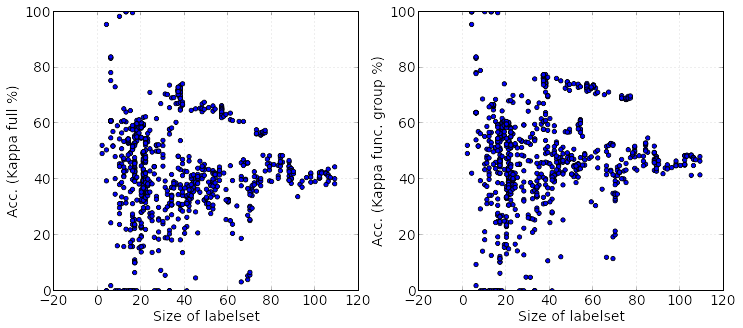

In [124]:


pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
plt.subplot(1, 2, 1)
plt.scatter(map(lambda x:x.nlabels, db), map(lambda x:x.fullkappa*100, db))
plt.ylim([0, 100])
plt.ylabel('Acc. (Kappa full %)')
plt.xlabel('Size of labelset')
plt.grid('on')

plt.subplot(1, 2, 2)
plt.scatter(map(lambda x:x.nlabels, db), map(lambda x:x.funckappa*100, db))
plt.ylim([0, 100])
plt.ylabel('Acc. (Kappa func. group %)')
plt.xlabel('Size of labelset')
plt.grid('on')
plt.savefig('cnstats_labelset_scatter.pdf')

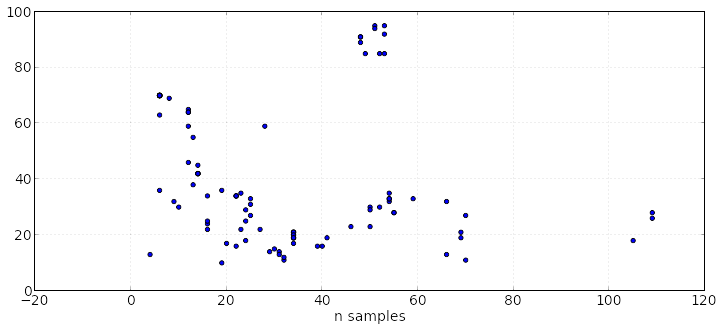

In [133]:
db_sub =[(x) for x in db if isinstance(x.allevation_level, (int, np.float32, np.float64))]

pylab.rcParams['figure.figsize'] = (12.0, 5.0) 
plt.scatter(map(lambda x:x.nlabels, db_sub), map(lambda x:x.allevation_level, db_sub))

plt.xlabel('n samples')
plt.grid('on')


In [108]:
ns = map(lambda x:x.nsamples_org, db)
np.argmax(ns)
db[2].source_id

np.argmax([None, 'N.A.', 12])
len(remove_small(db, 1000))


722